# CSC 440 Data Mining Final Project
## Better Decision Making for New York City Taxi Drivers
### Kefu Zhu, Chunlei Zhou

In [1]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from itertools import islice
import seaborn as sns
from scipy import stats
import numpy as np
import random
import sys
from collections import Counter,defaultdict
from sklearn.preprocessing import StandardScaler
import time

##### Data Pre-porcessing

In [2]:
# Load Data
print('Loading Data for Yellow Taxi...')
# yellow taxi
mar_y = pd.read_csv('/Users/zhouchunlei/Desktop/DATA SCIENCE/Data Mining/Homework/Final Project/yellow_tripdata_2018-03.csv')
aug_y = pd.read_csv('/Users/zhouchunlei/Desktop/DATA SCIENCE/Data Mining/Homework/Final Project/yellow_tripdata_2018-08.csv')
print('Yellow Taxi Data Loaded')
print('Loading Data for Green Taxi...')
# green taxi
mar_g = pd.read_csv('/Users/zhouchunlei/Desktop/DATA SCIENCE/Data Mining/Homework/Final Project/green_tripdata_2018-03.csv')
aug_g = pd.read_csv('/Users/zhouchunlei/Desktop/DATA SCIENCE/Data Mining/Homework/Final Project/green_tripdata_2018-08.csv')
print('Green Taxi Data Loaded')
print('All Data Loaded!')

Loading Data for Yellow Taxi...
Yellow Taxi Data Loaded
Loading Data for Green Taxi...
Green Taxi Data Loaded
All Data Loaded!


In [3]:
def preprocess(data):
    # Convert data type for categorical attribute
    data.VendorID = data.VendorID.astype(object)
    data.RatecodeID = data.RatecodeID.astype(object)
    data.PULocationID = data.PULocationID.astype(object)
    data.DOLocationID = data.DOLocationID.astype(object)
    data.payment_type = data.payment_type.astype(object)
    # Convert data type for date attribute
    data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime)
    data.tpep_dropoff_datetime = pd.to_datetime(data.tpep_dropoff_datetime)
    # Compute the duration of each trip and store in a new column, 'duration'
    print('Compute the duration of each taxi trip...')
    data['duration'] = data.tpep_dropoff_datetime - data.tpep_pickup_datetime
    # Compute tip percentage = tip/(total amount - tip) and store in a new column, 'tip_percentage'
    data.loc[:,'fare'] = data.total_amount - data.tip_amount
    data.loc[:, 'tip_percentage'] = data.tip_amount/data.fare
    # Create columns for pickup hour
    data.loc[:, 'tpep_pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
    # Create categotical data for pick up time and store in a new column, 'time'
    print('Create 5 different time periods: morning as 1, noon as 2, afternoon as 3, night as 4, latenight as 5...')
    pickup_hour = data['tpep_pickup_hour'].values.tolist()
    pickup_time = []
    for hour in pickup_hour:
        if 6 <= hour < 11:
            pickup_time.append(1)
        elif 11 <= hour < 14:
            pickup_time.append(2) 
        elif 14 <= hour < 18:
            pickup_time.append(3)
        elif 18 <= hour <= 23:
            pickup_time.append(4)
        elif 0<= hour < 6:
            pickup_time.append(5)
        else:
            pickup_time.append(0)
    data['time_period'] = pickup_time
    data.time_period = data.time_period.astype(object)
    # Remove unreasonable records
    print('Remove unreasonable records...')
    # 1. Taxi trips that last longer than 24 hours
    print('Remove trip records that last longer than 24 hours...')
    data = data.loc[[duration.days == 0 for duration in data.duration],]
    # 2. Taxi trips that travel more than 30 miles
    print('Remove trip records that travel more than 30 miles...')
    data = data.loc[data.trip_distance <= 30,]
    # 3. Taxi trips with non-positive total amount
    print('Remove trip records that have negative or zero total amount...')
    data = data.loc[data.total_amount > 0,]
    # 4. Taxi trips with negative tip amount
    print('Remove trip records that have negative tip amount...')
    data = data.loc[data.tip_amount >= 0,]
    # 5. Taxi trips with tip amount (almost) equals to total amount
    print('Remove trip records that have extremely large (abnormal) tip percentage...')
    data = data.loc[data.fare > 0,]
    # 6. Taxi trips with undefined time period
    print('Remove trip records that happened in undefined time periods...')
    data = data.loc[data.time_period != 0,]
    # 7. Taxi trips with tip larger than fare amount
    print('Remove trip records that have extremely large (abnormal) tip amount...')
    data = data.loc[data.tip_amount < data.fare,]
    # Reset row index
    print('Reset row index...')
    data.reset_index(inplace = True, drop = True)
    print('Taxi data preprocess completed!')
    return data

In [4]:
# Data Pre-processing
print('Data Pre-processing...')
print('    Preprocess Yellow Taxi Data...')
print('          March Data...')
mar_y = preprocess(mar_y)
print(mar_y.head())
print('          August Data...')
aug_y = preprocess(aug_y)
print(aug_y.head())
print('    Preprocess Green Taxi Data...')
print('          March Data...')
mar_g = preprocess(mar_g)
print(mar_g.head())
print('          August Data...')
aug_g = preprocess(aug_g)
print(aug_g.head())
print('General Data Pre-Processing Completed!')

Data Pre-processing...
    Preprocess Yellow Taxi Data...
          March Data...
Compute the duration of each taxi trip...
Create 5 different time periods: morning as 1, noon as 2, afternoon as 3, night as 4, latenight as 5...
Remove unreasonable records...
Remove trip records that last longer than 24 hours...
Remove trip records that travel more than 30 miles...
Remove trip records that have negative or zero total amount...
Remove trip records that have negative tip amount...
Remove trip records that have extremely large (abnormal) tip percentage...
Remove trip records that happened in undefined time periods...
Remove trip records that have extremely large (abnormal) tip amount...
Reset row index...
Taxi data preprocess completed!
  VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0        1  2018-03-01 00:01:34   2018-03-01 00:01:43                1   
1        1  2018-03-01 00:14:34   2018-03-01 00:28:13                1   
2        1  2018-03-01 00:51:25   2

Remove trip records that have negative tip amount...
Remove trip records that have extremely large (abnormal) tip percentage...
Remove trip records that happened in undefined time periods...
Remove trip records that have extremely large (abnormal) tip amount...
Reset row index...
Taxi data preprocess completed!
  VendorID tpep_pickup_datetime tpep_dropoff_datetime store_and_fwd_flag  \
0        2  2018-08-01 00:03:00   2018-08-01 00:17:00                  N   
1        2  2018-08-01 00:37:00   2018-08-01 00:46:00                  N   
2        2  2018-08-01 00:12:00   2018-08-01 00:20:00                  N   
3        2  2018-08-01 00:21:00   2018-08-01 00:27:00                  N   
4        2  2018-08-01 00:03:00   2018-08-01 00:06:00                  N   

  RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0          1          255           49              1.0           3.54   
1          1          256          112              1.0           1.94   
2       

# Where should the taxi drivers pick up passengers to get the highest tips?

In [5]:
def construct_dataframe(dataset):
    dataframe = {'Pickup_Location':[],'Tip_Percentage':[],'Tip_Amount':[]}
    for month in dataset:
        dataframe['Pickup_Location'].extend(list((month['PULocationID'])))
        dataframe['Tip_Percentage'].extend(list(month['tip_percentage']))
        dataframe['Tip_Amount'].extend(list(month['tip_amount']))
    return dataframe

def construct_dictionary(unique_location, dataframe):
    df = dataframe.groupby('Pickup_Location') 
    loc_dict = {}
    for loc in unique_location:
        tip_pct_list = list(df.get_group(loc)['Tip_Percentage']) 
        tip_list = list(df.get_group(loc)['Tip_Amount'])
        loc_dict[loc] = [tip_pct_list, tip_list]
    return loc_dict

def calculate_stats(loc_dict, unique_location):
    median = {'Location':[],'Median_Tip_Amount':[],'Median_Tip_Percentage':[]}
    maxi = {'Location':[],'Max_Tip_Amount':[],'Max_Tip_Percentage':[]}
    for loc in unique_location:
        tips = loc_dict[loc][1]
        percentage = loc_dict[loc][0]
        median['Location'].append(loc)
        median['Median_Tip_Amount'].append(statistics.median(tips))
        median['Median_Tip_Percentage'].append(statistics.median(percentage))
        maxi['Location'].append(loc)
        maxi['Max_Tip_Amount'].append(max(tips))
        maxi['Max_Tip_Percentage'].append(max(percentage))
    return median, maxi

def plot_loc_tip_pct_relationship(location, tip):
    plt.plot(location,tip)
    plt.ylabel('Median Tip Percentage')
    plt.xlabel('Pickup Location')
    tips = list(tip)
    i = tips.index(max(tips))
    loc = location[i]
    print('Best Location:',loc)
    # plt.axvline(x=loc, color='r', linestyle='-')
    plt.show()

def plot_loc_tip_amt_relationship(location, tip):
    plt.plot(location,tip)
    plt.ylabel('Median Tip Amount ($)')
    plt.xlabel('Pickup Location')
    tips = list(tip)
    i = tips.index(max(tips))
    loc = location[i]
    print('Best Location:',loc)
    # plt.axvline(x=loc, color='r', linestyle='-')
    plt.show()

In [8]:
print('Remove trip records that have abnormal tip amount...')
mar_y = mar_y.loc[mar_y.tip_amount <= 20,]
aug_y = aug_y.loc[aug_y.tip_amount <= 20,]
mar_g = mar_g.loc[mar_g.tip_amount <= 15,]
aug_g = aug_g.loc[aug_g.tip_amount <= 15,]
print('Remove trip records that have abnormal total amount...')
mar_y = mar_y.loc[mar_y.total_amount <= 125,]
mar_g = mar_g.loc[mar_g.total_amount <= 100,]
aug_y = aug_y.loc[aug_y.total_amount <= 125,]
aug_g = aug_g.loc[aug_g.total_amount <= 100,]
yellow_taxi = [mar_y, aug_y]
green_taxi = [mar_g, aug_g]
all_data = [yellow_taxi, green_taxi]
print('Remove trip records that paid in cash...')
for dataset in all_data:
    for month in dataset:
        month.loc[month.payment_type != 2,]
print('Construct the dataframe needed for this section...')
green_df = construct_dataframe(green_taxi)
green = pd.DataFrame(green_df, columns = ['Pickup_Location','Tip_Percentage','Tip_Amount'])
print('Green Taxi Dataframe Constructed!')
yellow_df = construct_dataframe(yellow_taxi)
yellow = pd.DataFrame(yellow_df, columns = ['Pickup_Location','Tip_Percentage','Tip_Amount'])
print('Yellow Taxi Dataframe Constructed!')
print('Get unique pickup locations for both taxi types...')
unique_loc_green = list(set(list(green['Pickup_Location'])))
unique_loc_yellow = list(set(list(yellow['Pickup_Location'])))
green_dict = construct_dictionary(unique_loc_green, green)
yellow_dict = construct_dictionary(unique_loc_yellow, yellow)
print('Data Pre-processing for Section 1 Finished!')

print('Statistical Analysis in Process...')
median_green, max_green = calculate_stats(green_dict, unique_loc_green)
median_green_df = pd.DataFrame(median_green, columns = ['Location','Median_Tip_Amount','Median_Tip_Percentage'])
max_green_df = pd.DataFrame(max_green, columns = ['Location','Max_Tip_Amount','Max_Tip_Percentage'])
median_yellow, max_yellow = calculate_stats(yellow_dict, unique_loc_yellow)
median_yellow_df = pd.DataFrame(median_yellow, columns = ['Location','Median_Tip_Amount','Median_Tip_Percentage'])
max_yellow_df = pd.DataFrame(max_yellow, columns = ['Location','Max_Tip_Amount','Max_Tip_Percentage'])

print('Get Ready to make suggestions...')
top10_median_green_tip, top10_max_green_tip = median_green_df.nlargest(10, ['Median_Tip_Amount']), max_green_df.nlargest(10, ['Max_Tip_Amount'])
top10_median_green_pct, top10_max_green_pct = median_green_df.nlargest(10,['Median_Tip_Percentage']), max_green_df.nlargest(10,['Max_Tip_Percentage'])
top10_median_yellow_tip, top10_max_yellow_tip = median_yellow_df.nlargest(10, ['Median_Tip_Amount']), max_yellow_df.nlargest(10, ['Max_Tip_Amount'])
top10_median_yellow_pct, top10_max_yellow_pct = median_yellow_df.nlargest(10,['Median_Tip_Percentage']), max_yellow_df.nlargest(10,['Max_Tip_Percentage'])
top_10_tips = [top10_median_yellow_tip, top10_max_yellow_tip,top10_median_green_tip, top10_max_green_tip]
top_10_pct = [top10_median_yellow_pct, top10_max_yellow_pct,top10_median_green_pct, top10_max_green_pct]
titles = ['Median Yellow','Max Yellow', 'Median Green', 'Max Green']

print('Analysis for Section 1 is Finished!')

Remove trip records that have abnormal tip amount...
Remove trip records that have abnormal total amount...
Remove trip records that paid in cash...
Construct the dataframe needed for this section...
Green Taxi Dataframe Constructed!
Yellow Taxi Dataframe Constructed!
Get unique pickup locations for both taxi types...
Data Pre-processing for Section 1 Finished!
Statistical Analysis in Process...
Get Ready to make suggestions...
Analysis for Section 1 is Finished!


Plot Our Results:
Green Taxi: Tip_Percentage Median - Pickup_Location Relationship
Best Location: 2.0


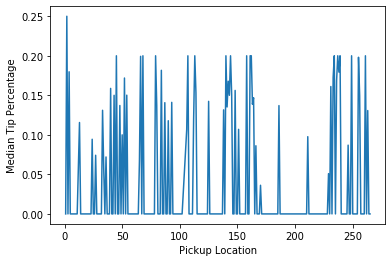

Green Taxi: Tip_Amount Median - Pickup_Location Relationship
Best Location: 84.0


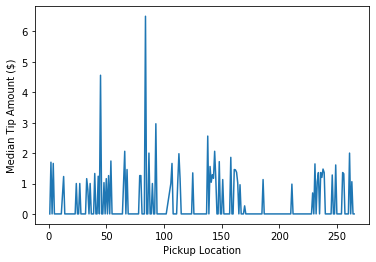

Yellow Taxi: Tip_Percentage Median - Pickup_Location Relationship
Best Location: 199


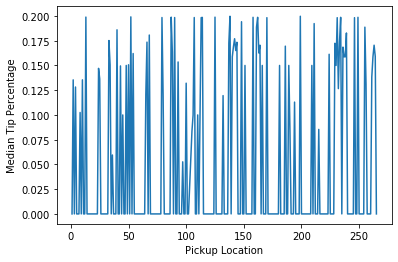

Yellow Taxi: Tip_Amount Median - Pickup_Location Relationship
Best Location: 199


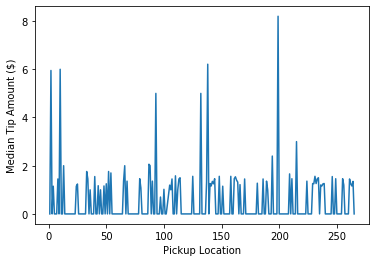

Suggest the Top 10 Pickup Locations for NYC Taxi Drives:
Top 10 Pickup Location to Earn Highest Tip Amount
Top 10 Based on Median Yellow are
     Location  Median_Tip_Amount  Median_Tip_Percentage
195       199               8.20               0.199708
134       138               6.21               0.199693
9          10               6.00               0.135463
1           2               5.95               0.135440
91         93               5.00               0.153505
128       132               5.00               0.119536
211       215               3.00               0.085383
190       194               2.40               0.112971
85         87               2.06               0.198795
12         13               2.00               0.198864
Top 10 Based on Max Yellow are
    Location  Max_Tip_Amount  Max_Tip_Percentage
0          1            20.0            0.860465
3          4            20.0            0.943396
6          7            20.0            0.985222
7          8    

In [9]:
print('Plot Our Results:')
print('Green Taxi: Tip_Percentage Median - Pickup_Location Relationship')
plot_loc_tip_pct_relationship(median_green_df['Location'],median_green_df['Median_Tip_Percentage'])
print('Green Taxi: Tip_Amount Median - Pickup_Location Relationship')
plot_loc_tip_amt_relationship(median_green_df['Location'],median_green_df['Median_Tip_Amount'])

print('Yellow Taxi: Tip_Percentage Median - Pickup_Location Relationship')
plot_loc_tip_pct_relationship(median_yellow_df['Location'],median_yellow_df['Median_Tip_Percentage'])
print('Yellow Taxi: Tip_Amount Median - Pickup_Location Relationship')
plot_loc_tip_amt_relationship(median_yellow_df['Location'],median_yellow_df['Median_Tip_Amount'])

print('Suggest the Top 10 Pickup Locations for NYC Taxi Drives:')

print('Top 10 Pickup Location to Earn Highest Tip Amount')
for i in range(len(titles)):
    print('Top 10 Based on', titles[i],'are')
    print(top_10_tips[i])
print('Top 10 Pickup Location to Earn Highest Tip Percentage')
for i in range(len(titles)):
    print('Top 10 Based on', titles[i],'are')
    print(top_10_pct[i])

# Does it worth for taxi drivers to work in the night?
## Use pairwise hypothesis test to reach a conclustion

In [10]:
def divide_night(dataset):
    day = [[],[]]
    night = [[],[]]
    pickup_hour = list(dataset['tpep_pickup_hour'])
    total_amount = list(dataset['total_amount'])
    for hour in range(len(pickup_hour)):
        if pickup_hour[hour] < 20 and pickup_hour[hour] >= 6:
            day[0].append(pickup_hour[hour])
            day[1].append(total_amount[hour])
        else:
            night[0].append(pickup_hour[hour])
            night[1].append(total_amount[hour])
    return day, night

def balance_sample_size(n,large_dataset):
    return random.sample(large_dataset,n)

def decide_N_and_large_ds(dsday, dsnight):
    n1 = len(dsday)
    n2 = len(dsnight)
    name1 = 'day'
    name2 = 'night'
    if n1 >= n2:
        large_ds = dsday
        small_n = n2
        large_name = name1
    else:
        large_ds = dsnight
        small_n = n1
        large_name = name2
    return small_n, large_ds, large_name

def t_test(day, night):
    # to do pairwise t test, balance sample size first
    N, large_dataset, name = decide_N_and_large_ds(day, night)
    df = N - 1
    P = []
    for i in range(5):
        if name == 'day':
            day2 = balance_sample_size(N, large_dataset)
            day = day2
        if name == 'night':
            night2 = balance_sample_size(N, large_dataset)
            night = day2
        difference = []
        for x in range(N):
            difference.append(day[x] - night[x])
        day_average = statistics.mean(day)
        night_average = statistics.mean(night)
        var = statistics.variance(difference)
        s = np.sqrt(var)
        t = (day_average - night_average) / (s / np.sqrt(N))
        p = stats.t.sf(np.abs(t), df)*2
        print('p-value =', p)
        P.append(p)
        #print('t =', t)
        #print('p-value =', p)
    print('Average p-value =', statistics.mean(P))
    if statistics.mean(P) < 0.05:
        print('Significant!')
    else:
        print('Non-Significant...')

Clean Data Further For This Secion...
Roughly 99.96% of the trip records have total_amount roughly less than 125 dollars (yellow taxi @ march)


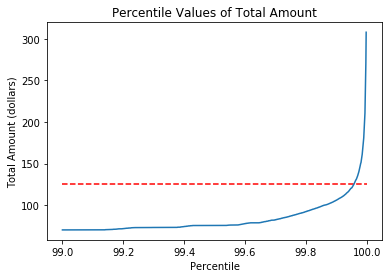

In [9]:
print('Clean Data Further For This Secion...')
# Compute the value of total amount for percentiles of 99.000, 99.001, ..., 99.999
X = np.arange(99,99.999,0.001)
Y = [np.percentile(mar_y.total_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(125, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') # Add horizontal red dashed line at 125
ax.set_title('Percentile Values of Total Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Total Amount (dollars)')
# choose percentile
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 125 dollars (yellow taxi @ march)'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-125))]))

Roughly 99.96% of the trip records have total_amount roughly less than 100 dollars (green taxi @ march)


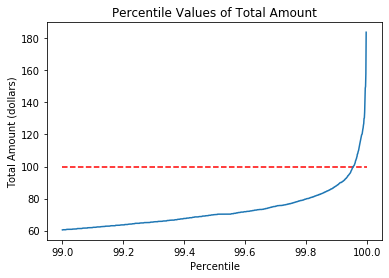

In [10]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(mar_g.total_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(100, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed')
ax.set_title('Percentile Values of Total Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Total Amount (dollars)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 100 dollars (green taxi @ march)'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-100))]))

Roughly 99.95% of the trip records have total_amount roughly less than 125 dollars (yellow taxi @ august)


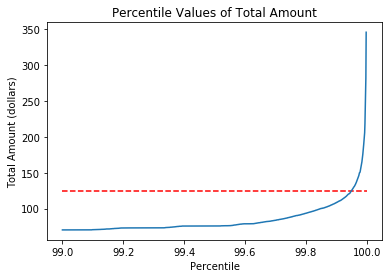

In [11]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(aug_y.total_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(125, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed')
ax.set_title('Percentile Values of Total Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Total Amount (dollars)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 125 dollars (yellow taxi @ august)'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-125))]))

Roughly 99.95% of the trip records have total_amount roughly less than 100 dollars (green taxi @ august)


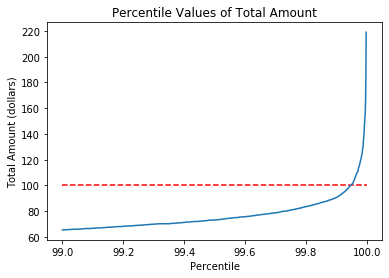

In [12]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(aug_g.total_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(100, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed')
ax.set_title('Percentile Values of Total Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Total Amount (dollars)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 100 dollars (green taxi @ august)'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-100))]))

In [11]:
print('Remove trip records that have abnormal total amount...')
mar_y = mar_y.loc[mar_y.total_amount <= 125,]
mar_g = mar_g.loc[mar_g.total_amount <= 100,]
aug_y = aug_y.loc[aug_y.total_amount <= 125,]
aug_g = aug_g.loc[aug_g.total_amount <= 100,]
yellow_taxi = [mar_y, aug_y]
green_taxi = [mar_g, aug_g]
all_data = [yellow_taxi, green_taxi]
print('Further Cleaning Finished')

Remove trip records that have abnormal total amount...
Further Cleaning Finished


In [12]:
print('Time Effect in Spring (March):')
print('For Green Taxi:')
mar_g_day, mar_g_night = divide_night(green_taxi[0])
day_average_mar_g = statistics.mean(mar_g_day[1])
night_average_mar_g = statistics.mean(mar_g_night[1])
print('Average Income in Day =',day_average_mar_g)
print('Average Income at Night =', night_average_mar_g)
print('For Yellow Taxi:')
mar_y_day, mar_y_night = divide_night(yellow_taxi[0])
day_average_mar_y = statistics.mean(mar_y_day[1])
night_average_mar_y = statistics.mean(mar_y_night[1])
print('Average Income in Day =', day_average_mar_y)
print('Average Income at Night =', night_average_mar_y)
print('Time Effect in Summer (August):')
print('For Green Taxi:')
aug_g_day, aug_g_night = divide_night(green_taxi[1])
day_average_aug_g = statistics.mean(aug_g_day[1])
night_average_aug_g = statistics.mean(aug_g_night[1])
print('Average Income in Day =', day_average_aug_g)
print('Average Income at Night =', night_average_aug_g)
print('For Yellow Taxi:')
aug_y_day, aug_y_night = divide_night(yellow_taxi[1])
day_average_aug_y = statistics.mean(aug_y_day[1])
night_average_aug_y = statistics.mean(aug_y_night[1])
print('Average Income in Day =', day_average_aug_y)
print('Average Income at Night =', night_average_aug_y)
# clear day earn more or night earn more

Time Effect in Spring (March):
For Green Taxi:
Average Income in Day = 15.288491014653028
Average Income at Night = 13.887772268622044
For Yellow Taxi:
Average Income in Day = 15.604411586487398
Average Income at Night = 16.160035799502072
Time Effect in Summer (August):
For Green Taxi:
Average Income in Day = 16.460830443883168
Average Income at Night = 15.276506135484956
For Yellow Taxi:
Average Income in Day = 16.14303545072107
Average Income at Night = 16.569148903791117


In [13]:
print('Confidence Level = 95%')
print('Significance Test for Green Taxi in Spring (March) ---- Pairwise Hypothesis Test:')
t_test(mar_g_day[1],mar_g_night[1])
print('Significance Test for Yellow Taxi in Spring (March) ---- Pairwise Hypothesis Test:')
t_test(mar_y_day[1], mar_y_night[1])

Confidence Level = 95%
Significance Test for Green Taxi in Spring (March) ---- Pairwise Hypothesis Test:
p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0
Average p-value = 0.0
Significant!
Significance Test for Yellow Taxi in Spring (March) ---- Pairwise Hypothesis Test:
p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0
Average p-value = 0.0
Significant!


In [12]:
print('Significance Test for Green Taxi in Summer (August) ---- Pairwise Hypothesis Test:')
t_test(aug_g_day[1], aug_g_night[1])
print('Significance Test for Yellow Taxi in Summer (August) ---- Pairwise Hypothesis Test:')
t_test(aug_y_day[1], aug_y_night[1])

Significance Test for Green Taxi in Summer (August) ---- Pairwise Hypothesis Test:
p-value = 9.13368849139264e-197
p-value = 1.0811229073500937e-196
p-value = 2.1264719506183408e-210
p-value = 4.310033346929972e-216
p-value = 2.6381800792226117e-203
Average p-value = 3.9889840406147735e-197
Significant!
Significance Test for Yellow Taxi in Summer (August) ---- Pairwise Hypothesis Test:
p-value = 1.7104960606687262e-259
p-value = 1.2265842597891304e-271
p-value = 7.587756363632426e-260
p-value = 2.52456047633945e-264
p-value = 4.0353646524480545e-237
Average p-value = 8.070729304896109e-238
Significant!


# Investigate Customer Profiles

In [14]:
print('Clean Data Further For This Secion...')
yellow_taxi = pd.concat([mar_y,aug_y])
green_taxi = pd.concat([mar_g,aug_g])

Clean Data Further For This Secion...


Roughly 99.77% of the trip records have total_amount roughly less than 9000 seconds


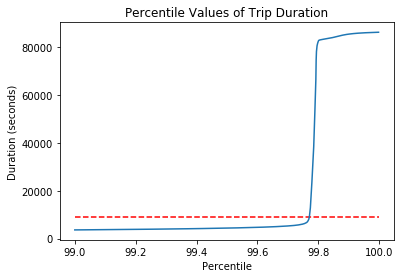

In [18]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(yellow_taxi.duration.dt.total_seconds(), x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(9000, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') 
ax.set_title('Percentile Values of Trip Duration')
ax.set_xlabel('Percentile'); ax.set_ylabel('Duration (seconds)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 9000 seconds'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-9000))]))

Roughly 99.45% of the trip records have total_amount roughly less than 10000 seconds


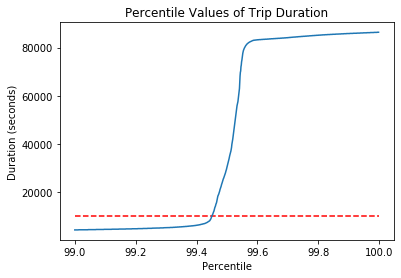

In [19]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(green_taxi.duration.dt.total_seconds(), x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(10000, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed') 
ax.set_title('Percentile Values of Trip Duration')
ax.set_xlabel('Percentile'); ax.set_ylabel('Duration (seconds)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 10000 seconds'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-10000))]))

Text(0, 0.5, 'Number of Passenger')

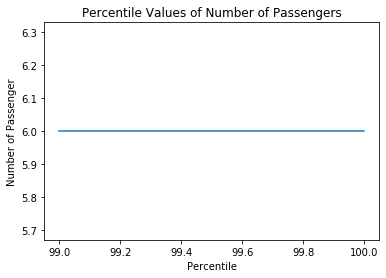

In [20]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(yellow_taxi.passenger_count, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.set_title('Percentile Values of Number of Passengers')
ax.set_xlabel('Percentile'); ax.set_ylabel('Number of Passenger')

Text(0, 0.5, 'Number of Passenger')

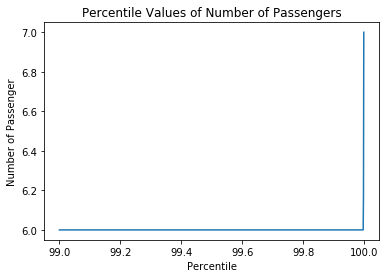

In [21]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(green_taxi.passenger_count, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.set_title('Percentile Values of Number of Passengers')
ax.set_xlabel('Percentile'); ax.set_ylabel('Number of Passenger')

Roughly 99.96% of the trip records have total_amount roughly less than 20 dollars


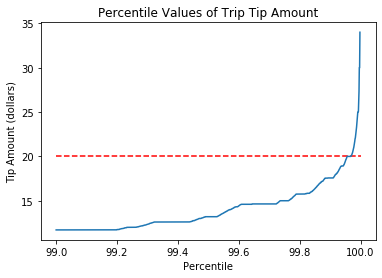

In [22]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(yellow_taxi.tip_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(20, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed')
ax.set_title('Percentile Values of Trip Tip Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Tip Amount (dollars)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 20 dollars'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-20))]))

Roughly 99.94% of the trip records have total_amount roughly less than 15 dollars


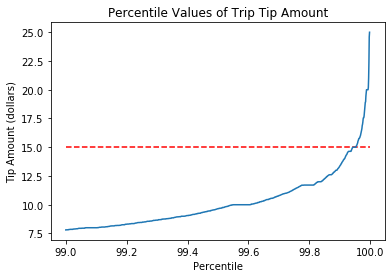

In [23]:
X = np.arange(99,99.999,0.001)
Y = [np.percentile(green_taxi.tip_amount, x) for x in X]
ax = sns.lineplot(x = X, y = Y)
ax.hlines(15, xmin = 99, xmax = 100, colors = 'red', linestyles='dashed')
ax.set_title('Percentile Values of Trip Tip Amount')
ax.set_xlabel('Percentile'); ax.set_ylabel('Tip Amount (dollars)')
print('Roughly {:.2f}% of the trip records have total_amount roughly less than 15 dollars'
      .format(X[min(range(len(Y)), key = lambda i: abs(Y[i]-15))]))

In [15]:
print('Remove trip records that have abnormal total amount...')
yellow_taxi = yellow_taxi.loc[yellow_taxi.total_amount <= 125,]
green_taxi = green_taxi.loc[green_taxi.total_amount <= 100,]
print('Convert duration in hh:mm:ss to duration in total seconds...')
yellow_taxi['duration_in_seconds'] = yellow_taxi.duration.dt.total_seconds()
green_taxi['duration_in_seconds'] = green_taxi.duration.dt.total_seconds()
print('Remove trip records that have abnormal duration...')
yellow_taxi = yellow_taxi.loc[yellow_taxi.duration_in_seconds <= 9000,]
green_taxi = green_taxi.loc[green_taxi.duration_in_seconds <= 10000,]
print('Remove trip records that have abnormal tip amount...')
yellow_taxi = yellow_taxi.loc[yellow_taxi.tip_amount <= 20,]
green_taxi = green_taxi.loc[green_taxi.tip_amount <= 15,]
print('Further Cleaning Finished')

Remove trip records that have abnormal total amount...
Convert duration in hh:mm:ss to duration in total seconds...
Remove trip records that have abnormal duration...
Remove trip records that have abnormal tip amount...
Further Cleaning Finished


In [16]:
def plot_cluster_per_atttribute_3(attribute_number,cluster_1,cluster_2,cluster_3,attribute_name):
    cluster_1_attribute = []
    cluster_2_attribute = []
    cluster_3_attribute = []
    for point in cluster_1:
        cluster_1_attribute.append(point[attribute_number])
    for point in cluster_2:
        cluster_2_attribute.append(point[attribute_number])
    for point in cluster_3:
        cluster_3_attribute.append(point[attribute_number])
    df1 = pd.DataFrame({'1':cluster_1_attribute})
    df2 = pd.DataFrame({'2':cluster_2_attribute})
    df3 = pd.DataFrame({'3':cluster_3_attribute})
    cluster_duration_in_seconds = pd.concat([df1,df2,df3], ignore_index=True, axis=1)
    sns.boxplot(data=cluster_duration_in_seconds).set(xlabel='Cluster Label', ylabel=attribute_name)
    plt.show()

def plot_cluster_per_atttribute_5(attribute_number,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,attribute_name):
    cluster_1_attribute = []
    cluster_2_attribute = []
    cluster_3_attribute = []
    cluster_4_attribute = []
    cluster_5_attribute = []
    for point in cluster_1:
        cluster_1_attribute.append(point[attribute_number])
    for point in cluster_2:
        cluster_2_attribute.append(point[attribute_number])
    for point in cluster_3:
        cluster_3_attribute.append(point[attribute_number])
    for point in cluster_4:
        cluster_4_attribute.append(point[attribute_number])
    for point in cluster_5:
        cluster_5_attribute.append(point[attribute_number])
    df1 = pd.DataFrame({'1':cluster_1_attribute})
    df2 = pd.DataFrame({'2':cluster_2_attribute})
    df3 = pd.DataFrame({'3':cluster_3_attribute})
    df4 = pd.DataFrame({'4':cluster_4_attribute})
    df5 = pd.DataFrame({'5':cluster_5_attribute})
    cluster_duration_in_seconds = pd.concat([df1,df2,df3,df4,df5], ignore_index=True, axis=1)
    sns.boxplot(data=cluster_duration_in_seconds).set(xlabel='Cluster Label', ylabel=attribute_name)
    plt.show()

def plot_cluster_per_atttribute_10(attribute_number,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,
                                  cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,attribute_name):
    cluster_1_attribute = []
    cluster_2_attribute = []
    cluster_3_attribute = []
    cluster_4_attribute = []
    cluster_5_attribute = []
    cluster_6_attribute = []
    cluster_7_attribute = []
    cluster_8_attribute = []
    cluster_9_attribute = []
    cluster_10_attribute = []
    for point in cluster_1:
        cluster_1_attribute.append(point[attribute_number])
    for point in cluster_2:
        cluster_2_attribute.append(point[attribute_number])
    for point in cluster_3:
        cluster_3_attribute.append(point[attribute_number])
    for point in cluster_4:
        cluster_4_attribute.append(point[attribute_number])
    for point in cluster_5:
        cluster_5_attribute.append(point[attribute_number])
    for point in cluster_6:
        cluster_6_attribute.append(point[attribute_number])
    for point in cluster_7:
        cluster_7_attribute.append(point[attribute_number])
    for point in cluster_8:
        cluster_8_attribute.append(point[attribute_number])
    for point in cluster_9:
        cluster_9_attribute.append(point[attribute_number])
    for point in cluster_10:
        cluster_10_attribute.append(point[attribute_number])
    df1 = pd.DataFrame({'1':cluster_1_attribute})
    df2 = pd.DataFrame({'2':cluster_2_attribute})
    df3 = pd.DataFrame({'3':cluster_3_attribute})
    df4 = pd.DataFrame({'4':cluster_4_attribute})
    df5 = pd.DataFrame({'5':cluster_5_attribute})
    df6 = pd.DataFrame({'6':cluster_6_attribute})
    df7 = pd.DataFrame({'7':cluster_7_attribute})
    df8 = pd.DataFrame({'8':cluster_8_attribute})
    df9 = pd.DataFrame({'9':cluster_9_attribute})
    df10 = pd.DataFrame({'10':cluster_10_attribute})
    cluster_duration_in_seconds = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10], ignore_index=True, axis=1)
    sns.boxplot(data=cluster_duration_in_seconds).set(xlabel='Cluster Label', ylabel=attribute_name)
    plt.show()

## Numeric Attributes

In [17]:
def select_numeric_features(DS, features):
    D_df = DS.loc[:,features]
    D_norm = StandardScaler().fit_transform(D_df)
    #D = D_norm.tolist()
    return D_norm

def get_initial_random_centors(k, D):
    centors = []
    indexes = list(np.arange(0,len(D)))
    centor_index = random.sample(indexes, k)
    for centor in centor_index:
        centors.append(D[centor])
    return centors

def compute_euclidean_distance(x, centor):
    #sum_dist = np.sum([(x[i]-centor[i])**2 for i in range(len(centor))])
    #return np.sqrt(sum_dist)
    return np.linalg.norm(np.array(x)-np.array(centor))

def assign_to_cluster(X, centors):
    clusters = defaultdict(list)
    for x in X:
        cluster = np.argsort([compute_euclidean_distance(x[:-1], c[:-1]) for c in centors])[0]
        clusters[cluster].append(x)
    return clusters

def update_centors(clusters, centors):
    new_centors = []
    keys = sorted(clusters.keys())
    for k in keys:
        if clusters[k]:
            new_centor = np.mean(clusters[k], axis = 0)
            new_centor[len(clusters[0][0])-1] = Counter([clusters[k][i][-1] for i in range(len(clusters[k]))]).most_common(1)[0][0]
            new_centors.append(new_centor)
        else:
            new_centors.append(centors[k])
    return new_centors

def check_change(old_centors, new_centors):
    return set([tuple(a) for a in new_centors]) == set([tuple(b) for b in old_centors])

def k_means(k,D):
    centors = get_initial_random_centors(k, D)
    no_change = False
    iteration = 0
    while no_change != True:
        print(no_change,'iteration',iteration)
        k_clusters = assign_to_cluster(D, centors)
        new_centors = update_centors(k_clusters, centors)
        no_change = check_change(centors, new_centors)
        centors = new_centors
        iteration += 1
    print(centors)
    return k_clusters

In [18]:
numeric_features = ['duration_in_seconds','passenger_count','trip_distance','tip_amount','total_amount']
seed = 0
yellow_sample = yellow_taxi.groupby(['time_period']).apply(lambda x: x.sample(n = len(x)//100, random_state = seed))
green_sample = green_taxi.groupby(['time_period']).apply(lambda x: x.sample(n = len(x)//100, random_state = seed))
numeric_yellow = select_numeric_features(yellow_sample,numeric_features)
numeric_green = select_numeric_features(green_sample,numeric_features)
print(numeric_yellow[:5])
print(numeric_green[:5])
print(len(numeric_yellow))
print(len(numeric_green))

[[-0.01101889  2.73017706 -0.35517192 -0.34760997 -0.31593845]
 [-1.05268437 -0.48407554 -0.69347539 -0.31338278 -0.7975501 ]
 [-0.61667296 -0.48407554 -0.45260332 -0.77544977 -0.65351671]
 [-0.65833958 -0.48407554 -0.49319974 -0.34760997 -0.57849932]
 [-0.98125588 -0.48407554 -0.59875042 -0.32621798 -0.72478323]]
[[-0.52810827 -0.34161666 -0.59183695 -0.57737893 -0.67644135]
 [-0.52810827 -0.34161666 -0.54787939 -0.57737893 -0.6326286 ]
 [-0.36526849 -0.34161666  0.01477741  0.86955739 -0.06656783]
 [-0.60952815 -0.34161666 -0.44824225 -0.57737893 -0.67644135]
 [-0.69094804  0.61719518 -0.63579452 -0.57737893 -0.76406685]]
171939
14853


In [18]:
K = [3,5,10]
print('For k in K ( K =',K,'), implement k-means algorithm.')
print('K-Means Clustering: Get Customer Profile for Yellow Taxi')

For k in K ( K = [3, 5, 10] ), implement k-means algorithm.
K-Means Clustering: Get Customer Profile for Yellow Taxi


In [38]:
k1 = 3
print('k =',k1)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_1 = k_means(k1, numeric_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 3 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))


k = 3
Start at 03:00:57
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
[array([ 2.1456608 , -0.06147321,  2.49422395,  1.91379844,  3.19187472]), array([-0.23447445, -0.3556098 , -0.27042952, -0.20282192, -0.65351671]), array([-0.17027978,  2.29010631, -0.21140965, -0.19170817, -0.61600802])]
Stop at 03:33:22
K-Means Clustering with k = 3 on 171,939 data points took 32.43 minutes


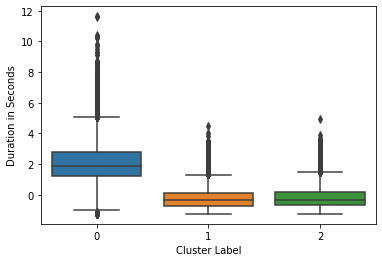

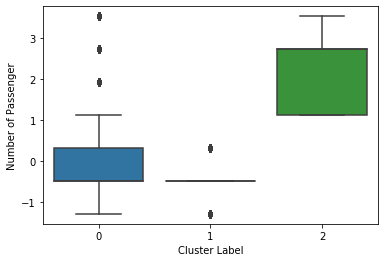

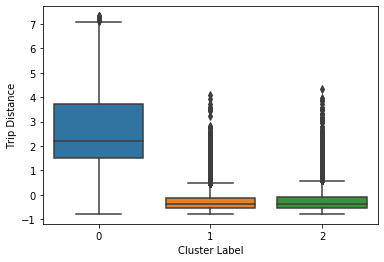

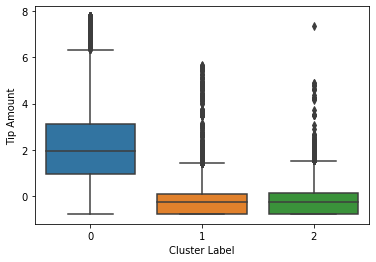

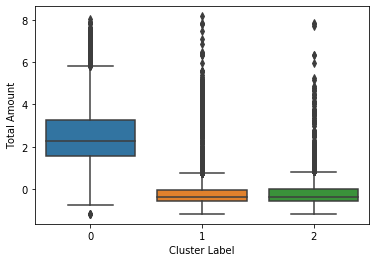

In [39]:
cluster_1 = k_clusters_yellow_1[0]
cluster_2 = k_clusters_yellow_1[1]
cluster_3 = k_clusters_yellow_1[2]
plot_cluster_per_atttribute_3(0,cluster_1,cluster_2,cluster_3,'Duration in Seconds')
plot_cluster_per_atttribute_3(1,cluster_1,cluster_2,cluster_3,'Number of Passenger')
plot_cluster_per_atttribute_3(2,cluster_1,cluster_2,cluster_3,'Trip Distance')
plot_cluster_per_atttribute_3(3,cluster_1,cluster_2,cluster_3,'Tip Amount')
plot_cluster_per_atttribute_3(4,cluster_1,cluster_2,cluster_3,'Total Amount')

In [40]:
k2 = 5
print('k =', k2)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_2 = k_means(k2, numeric_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 5 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 5
Start at 03:33:47
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
False iteration 14
False iteration 15
False iteration 16
False iteration 17
False iteration 18
False iteration 19
False iteration 20
False iteration 21
False iteration 22
False iteration 23
False iteration 24
False iteration 25
False iteration 26
False iteration 27
False iteration 28
False iteration 29
False iteration 30
False iteration 31
False iteration 32
False iteration 33
False iteration 34
False iteration 35
False iteration 36
False iteration 37
[array([ 2.23808455, -0.01719814,  2.82773936,  3.32161391,  4.07032836]), array([ 0.62394813, -0.28293245,  0.28425057,  0.40526329, -0.04887654]), array([ 2.70688886,  0.05405805,  3.07840342, -0.56116145,  3.19187472]), array([-0.16821841,  2.79968117, -0.20374

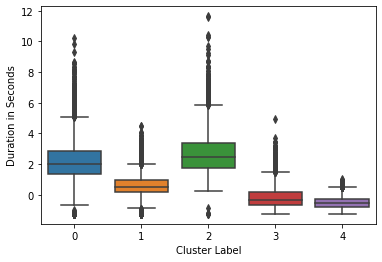

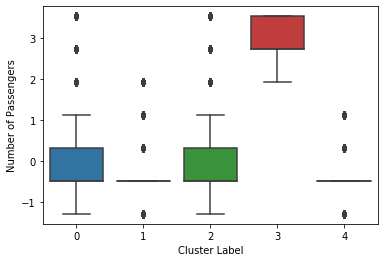

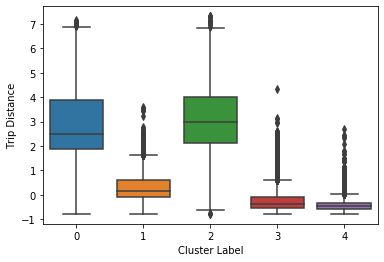

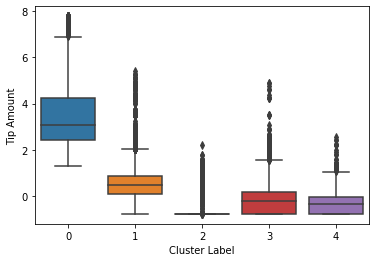

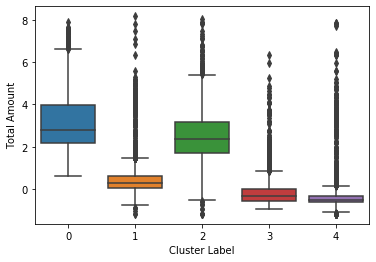

In [41]:
cluster_1 = k_clusters_yellow_2[0]
cluster_2 = k_clusters_yellow_2[1]
cluster_3 = k_clusters_yellow_2[2]
cluster_4 = k_clusters_yellow_2[3]
cluster_5 = k_clusters_yellow_2[4]
plot_cluster_per_atttribute_5(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Duration in Seconds')
plot_cluster_per_atttribute_5(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Number of Passengers')
plot_cluster_per_atttribute_5(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Trip Distance')
plot_cluster_per_atttribute_5(3,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Tip Amount')
plot_cluster_per_atttribute_5(4,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Total Amount')

In [42]:
k3 = 10
print('k =',k3)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_3 = k_means(k3, numeric_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 10 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 10
Start at 05:02:07
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
False iteration 14
False iteration 15
False iteration 16
False iteration 17
False iteration 18
False iteration 19
False iteration 20
False iteration 21
False iteration 22
False iteration 23
False iteration 24
False iteration 25
False iteration 26
False iteration 27
False iteration 28
False iteration 29
False iteration 30
False iteration 31
False iteration 32
False iteration 33
False iteration 34
False iteration 35
False iteration 36
False iteration 37
False iteration 38
False iteration 39
False iteration 40
False iteration 41
False iteration 42
False iteration 43
False iteration 44
False iteration 45
False iteration 46
False iteration 47
False iteration 48
False iteration 49
False iteration 50
False iteration 

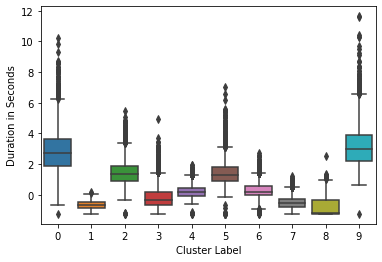

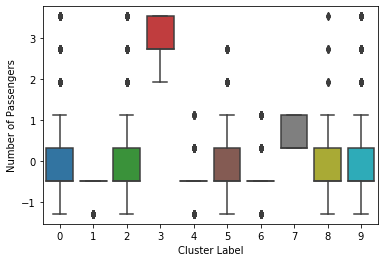

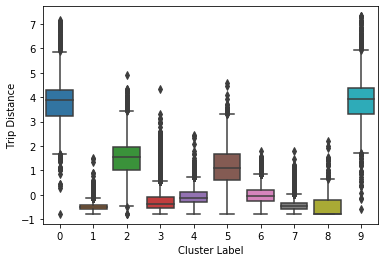

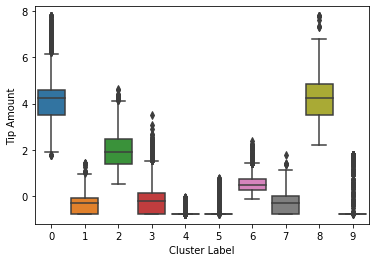

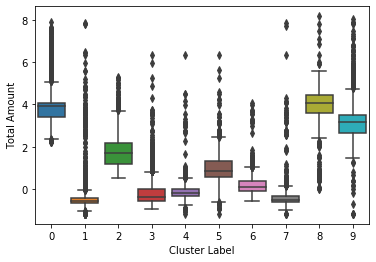

In [43]:
cluster_1 = k_clusters_yellow_3[0]
cluster_2 = k_clusters_yellow_3[1]
cluster_3 = k_clusters_yellow_3[2]
cluster_4 = k_clusters_yellow_3[3]
cluster_5 = k_clusters_yellow_3[4]
cluster_6 = k_clusters_yellow_3[5]
cluster_7 = k_clusters_yellow_3[6]
cluster_8 = k_clusters_yellow_3[7]
cluster_9 = k_clusters_yellow_3[8]
cluster_10 = k_clusters_yellow_3[9]
plot_cluster_per_atttribute_10(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Duration in Seconds')
plot_cluster_per_atttribute_10(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Number of Passengers')
plot_cluster_per_atttribute_10(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Trip Distance')
plot_cluster_per_atttribute_10(3,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Tip Amount')
plot_cluster_per_atttribute_10(4,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Total Amount')

In [44]:
print('K-Means Clustering: Get Customer Profile for Green Taxi')
k1 = 3
print('k =',k1)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_1 = k_means(k1, numeric_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 3 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

K-Means Clustering: Get Customer Profile for Green Taxi
k = 3
Start at 16:38:03
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
False iteration 14
False iteration 15
False iteration 16
[array([-0.33141961, -0.23129624, -0.34314902, -0.17446882, -0.67644135]), array([ 1.64692731, -0.20083715,  1.70327047,  0.83327578,  0.9446305 ]), array([-0.15125324,  3.73333365, -0.15107945,  0.01623064, -0.7202541 ])]
Stop at 16:38:14
K-Means Clustering with k = 3 on 171,939 data points took 0.19 minutes


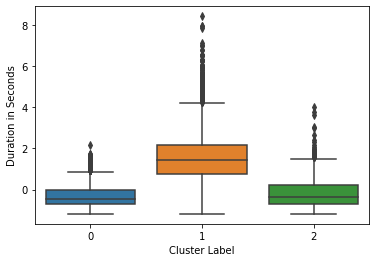

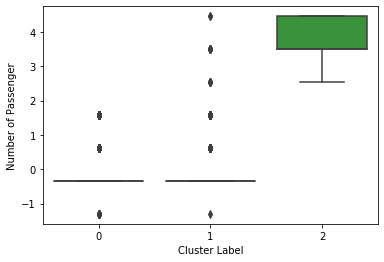

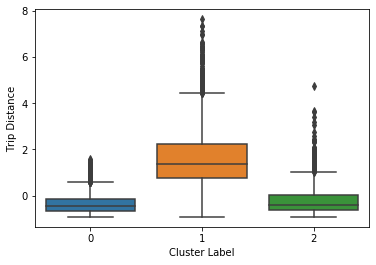

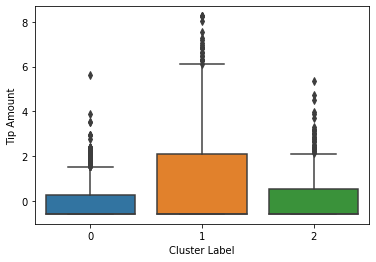

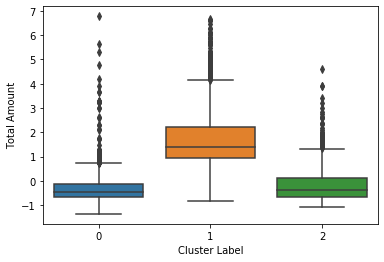

In [45]:
cluster_1 = k_clusters_green_1[0]
cluster_2 = k_clusters_green_1[1]
cluster_3 = k_clusters_green_1[2]
plot_cluster_per_atttribute_3(0,cluster_1,cluster_2,cluster_3,'Duration in Seconds')
plot_cluster_per_atttribute_3(1,cluster_1,cluster_2,cluster_3,'Number of Passenger')
plot_cluster_per_atttribute_3(2,cluster_1,cluster_2,cluster_3,'Trip Distance')
plot_cluster_per_atttribute_3(3,cluster_1,cluster_2,cluster_3,'Tip Amount')
plot_cluster_per_atttribute_3(4,cluster_1,cluster_2,cluster_3,'Total Amount')

In [46]:
k2 = 5
print('k =',k2)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_2 = k_means(k2, numeric_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 5 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 5
Start at 16:38:24
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
False iteration 14
False iteration 15
False iteration 16
False iteration 17
False iteration 18
False iteration 19
False iteration 20
False iteration 21
False iteration 22
False iteration 23
False iteration 24
False iteration 25
False iteration 26
False iteration 27
False iteration 28
False iteration 29
False iteration 30
False iteration 31
False iteration 32
False iteration 33
[array([ 0.79242858, -0.23008295,  0.60701197, -0.5018008 ,  0.1121882 ]), array([-0.50770358, -0.23145053, -0.48564858, -0.1925306 , -0.67644135]), array([ 0.76342711, -0.1956541 ,  0.87315143,  2.29764231,  0.24888399]), array([ 3.06373991, -0.14227605,  3.25340246, -0.51518488,  1.95232381]), array([-0.16666212,  3.73219221, -0.1786044

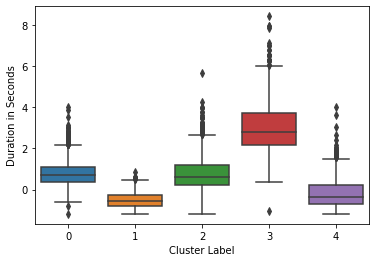

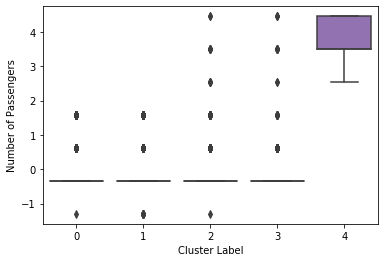

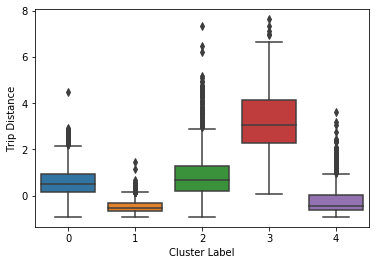

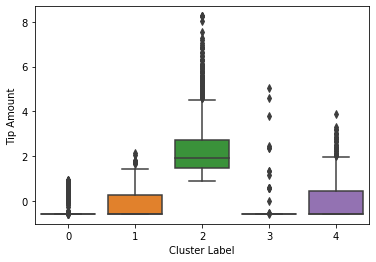

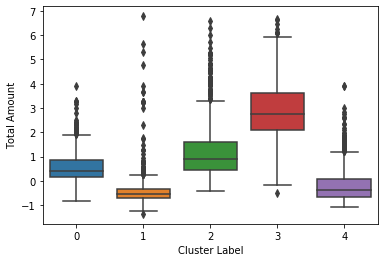

In [47]:
cluster_1 = k_clusters_green_2[0]
cluster_2 = k_clusters_green_2[1]
cluster_3 = k_clusters_green_2[2]
cluster_4 = k_clusters_green_2[3]
cluster_5 = k_clusters_green_2[4]
plot_cluster_per_atttribute_5(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Duration in Seconds')
plot_cluster_per_atttribute_5(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Number of Passengers')
plot_cluster_per_atttribute_5(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Trip Distance')
plot_cluster_per_atttribute_5(3,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Tip Amount')
plot_cluster_per_atttribute_5(4,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Total Amount')

In [48]:
k3 = 10
print('k =',k3)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_3 = k_means(k3, numeric_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Means Clustering with k = 10 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 10
Start at 16:39:17
False iteration 0
False iteration 1
False iteration 2
False iteration 3
False iteration 4
False iteration 5
False iteration 6
False iteration 7
False iteration 8
False iteration 9
False iteration 10
False iteration 11
False iteration 12
False iteration 13
False iteration 14
False iteration 15
False iteration 16
False iteration 17
False iteration 18
False iteration 19
False iteration 20
False iteration 21
False iteration 22
False iteration 23
False iteration 24
False iteration 25
False iteration 26
False iteration 27
False iteration 28
False iteration 29
False iteration 30
False iteration 31
False iteration 32
False iteration 33
False iteration 34
False iteration 35
False iteration 36
False iteration 37
[array([-0.41457408,  3.72700718, -0.42217279, -0.20307907, -0.7202541 ]), array([ 3.86574734, -0.18673167,  4.22136964, -0.55034502,  2.74095335]), array([-0.46841809,  0.81877544, -0.45345842, -0.33993267, -0.67644135]), array([-0.02172198, -0.27200645, -0.0573

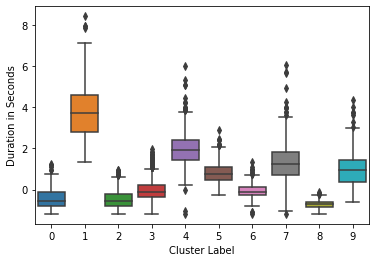

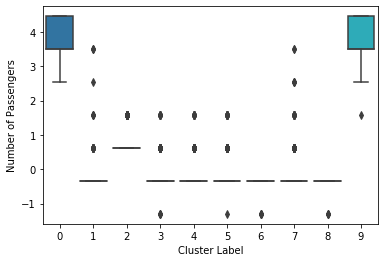

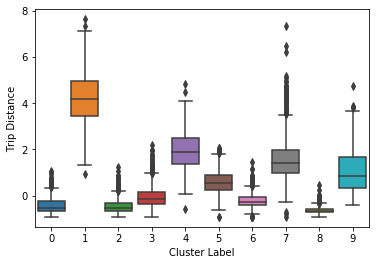

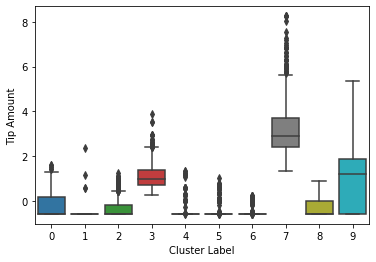

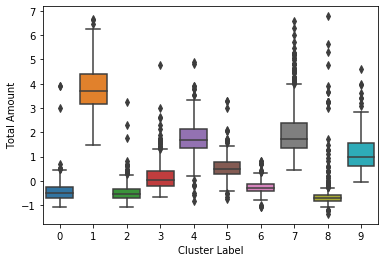

In [49]:
cluster_1 = k_clusters_green_3[0]
cluster_2 = k_clusters_green_3[1]
cluster_3 = k_clusters_green_3[2]
cluster_4 = k_clusters_green_3[3]
cluster_5 = k_clusters_green_3[4]
cluster_6 = k_clusters_green_3[5]
cluster_7 = k_clusters_green_3[6]
cluster_8 = k_clusters_green_3[7]
cluster_9 = k_clusters_green_3[8]
cluster_10 = k_clusters_green_3[9]
plot_cluster_per_atttribute_10(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Duration in Seconds')
plot_cluster_per_atttribute_10(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Number of Passengers')
plot_cluster_per_atttribute_10(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Trip Distance')
plot_cluster_per_atttribute_10(3,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Tip Amount')
plot_cluster_per_atttribute_10(4,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Total Amount')

## Categorical Attributes

In [19]:
def select_categorical_features(DS, features):
    D_df = DS.loc[:,features]
    D = D_df.values.tolist()
    return D

def get_initial_unique_random_centors(k, D):
    centors = []
    count = 0
    indexes = list(np.arange(0,len(D)))
    while count != k:
        centor_index = random.sample(indexes, 1)
        centor_candidate = D[centor_index[0]]
        if centor_candidate not in centors:
            centors.append(centor_candidate)
            count += 1    
    return centors

def compute_similarity(x, centor):
    return np.sum(np.array(x) != np.array(centor), axis = 0)

def assign_to_modes_cluster(X, centors):
    clusters = defaultdict(list)
    for x in X:
        cluster = np.argsort([compute_similarity(x[:-1], c[:-1]) for c in centors])[0]
        clusters[cluster].append(x)
    return clusters

def update_mode_centors(clusters, centors, K):
    new_centors = []
    keys = sorted(clusters.keys())
    for k in keys:
        if clusters[k]:
            new_centor = stats.mode(clusters[k])[0]
            new_centors.append(new_centor[0])
        else:
            new_centors.append(centors[k])
    if K > len(keys):
        difference = K - len(keys)
        for i in range(difference):
            new_centors.append(np.array(centors[len(keys)+i]))
            clusters[len(keys)+i].append(centors[len(keys)+i])
    return new_centors,clusters

def k_modes(k,D):
    centors = get_initial_unique_random_centors(k, D)
    no_change = False
    iteration = 0
    while no_change != True:
        print(centors)
        print(no_change,'iteration',iteration)
        k_clusters = assign_to_modes_cluster(D, centors)
        new_centors,new_k_clusters = update_mode_centors(k_clusters, centors,k)
        no_change = check_change(centors, new_centors)
        centors = new_centors
        k_clusters = new_k_clusters
        iteration += 1
    print(centors)
    return k_clusters

In [20]:
print('For categorical features, use k-modes algorithm instead.')
nominal_features = ['time_period','RatecodeID','payment_type']
seed = 0
yellow_sample = yellow_taxi.groupby(['time_period']).apply(lambda x: x.sample(n = len(x)//100, random_state = seed))
green_sample = green_taxi.groupby(['time_period']).apply(lambda x: x.sample(n = len(x)//100, random_state = seed))
categorical_yellow = select_categorical_features(yellow_sample,nominal_features)
categorical_green = select_categorical_features(green_sample,nominal_features)
print(categorical_yellow[:5])
print(categorical_green[:5])
print(len(categorical_yellow))
print(len(categorical_green))

For categorical features, use k-modes algorithm instead.
[[1, 1, 1], [1, 1, 1], [1, 1, 2], [1, 1, 1], [1, 1, 1]]
[[1, 1.0, 2.0], [1, 1.0, 1.0], [1, 1.0, 1.0], [1, 1.0, 2.0], [1, 1.0, 2.0]]
171939
14853


In [213]:
K = [3,5,10]
print('For k in K ( K =',K,'), implement k-modes algorithm.')
print('K-Modes Clustering: Get Customer Profile for Yellow Taxi')

For k in K ( K = [3, 5, 10] ), implement k-modes algorithm.
K-Modes Clustering: Get Customer Profile for Yellow Taxi


In [21]:
k1 = 3
print('k =',k1)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_modes1 = k_modes(k1, categorical_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 3 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 3
Start at 05:00:47
[[1, 1, 1], [3, 1, 2], [4, 1, 2]]
False iteration 0
[array([1, 1, 1]), array([3, 1, 1]), array([4, 1, 1])]
False iteration 1
[array([1, 1, 1]), array([3, 1, 1]), array([4, 1, 1])]
Stop at 05:01:00
K-Modes Clustering with k = 3 on 171,939 data points took 0.21 minutes


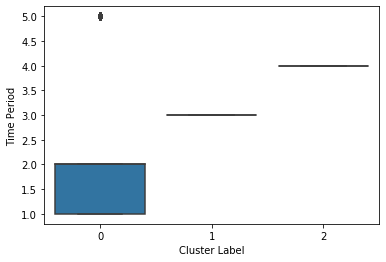

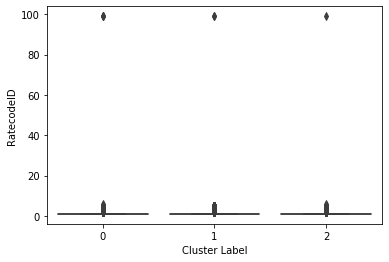

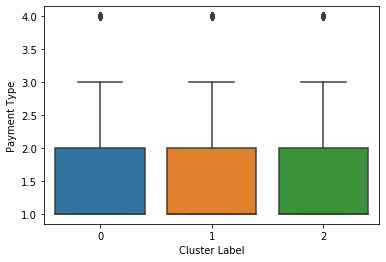

In [22]:
cluster_1 = k_clusters_yellow_modes1[0]
cluster_2 = k_clusters_yellow_modes1[1]
cluster_3 = k_clusters_yellow_modes1[2]
plot_cluster_per_atttribute_3(0,cluster_1,cluster_2,cluster_3,'Time Period')
plot_cluster_per_atttribute_3(1,cluster_1,cluster_2,cluster_3,'RatecodeID')
plot_cluster_per_atttribute_3(2,cluster_1,cluster_2,cluster_3,'Payment Type')

In [23]:
k2 = 5
print('k =',k2)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_modes2 = k_modes(k2, categorical_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 5 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 5
Start at 05:01:07
[[1, 1, 1], [3, 1, 1], [3, 3, 2], [2, 1, 1], [4, 1, 2]]
False iteration 0
[array([1, 1, 1]), array([3, 1, 1]), array([3, 3, 1]), array([2, 1, 1]), array([4, 1, 1])]
False iteration 1
[array([1, 1, 1]), array([3, 1, 1]), array([3, 3, 1]), array([2, 1, 1]), array([4, 1, 1])]
Stop at 05:01:24
K-Modes Clustering with k = 5 on 171,939 data points took 0.29 minutes


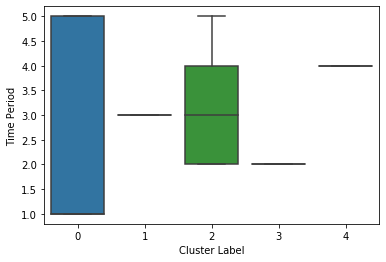

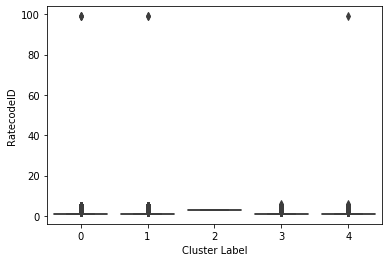

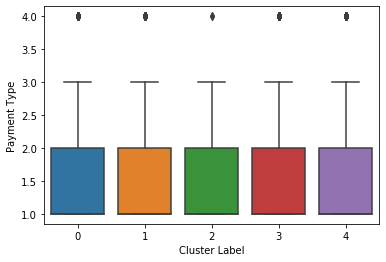

In [24]:
cluster_1 = k_clusters_yellow_modes2[0]
cluster_2 = k_clusters_yellow_modes2[1]
cluster_3 = k_clusters_yellow_modes2[2]
cluster_4 = k_clusters_yellow_modes2[3]
cluster_5 = k_clusters_yellow_modes2[4]
plot_cluster_per_atttribute_5(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Time Period')
plot_cluster_per_atttribute_5(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'RatecodeID')
plot_cluster_per_atttribute_5(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Payment Type')

In [25]:
k3 = 10
print('k =',k3)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_yellow_modes3 = k_modes(k3, categorical_yellow)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 10 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 10
Start at 05:01:34
[[5, 1, 2], [4, 1, 1], [4, 1, 2], [1, 2, 2], [5, 1, 1], [2, 1, 1], [2, 1, 2], [3, 1, 2], [1, 1, 1], [3, 1, 1]]
False iteration 0
[array([5, 1, 1]), array([4, 1, 1]), array([3, 2, 1]), array([2, 1, 1]), array([3, 1, 1]), array([1, 1, 1]), array([2, 1, 2]), array([3, 1, 2]), array([1, 1, 1]), array([3, 1, 1])]
False iteration 1
[array([5, 1, 1]), array([4, 1, 1]), array([3, 2, 1]), array([2, 1, 1]), array([3, 1, 1]), array([1, 1, 1]), array([2, 1, 2]), array([3, 1, 2]), array([1, 1, 1]), array([3, 1, 1])]
Stop at 05:02:09
K-Modes Clustering with k = 10 on 171,939 data points took 0.59 minutes


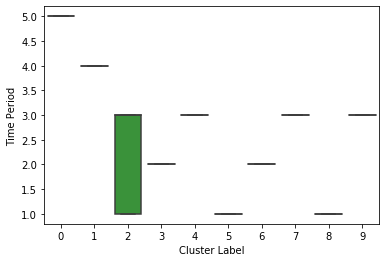

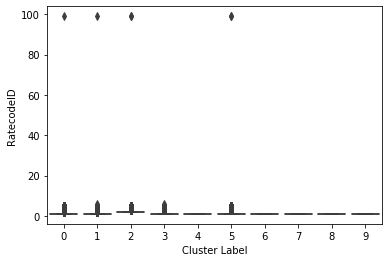

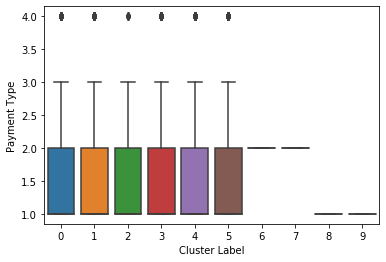

In [26]:
cluster_1 = k_clusters_yellow_modes3[0]
cluster_2 = k_clusters_yellow_modes3[1]
cluster_3 = k_clusters_yellow_modes3[2]
cluster_4 = k_clusters_yellow_modes3[3]
cluster_5 = k_clusters_yellow_modes3[4]
cluster_6 = k_clusters_yellow_modes3[5]
cluster_7 = k_clusters_yellow_modes3[6]
cluster_8 = k_clusters_yellow_modes3[7]
cluster_9 = k_clusters_yellow_modes3[8]
cluster_10 = k_clusters_yellow_modes3[9]
plot_cluster_per_atttribute_10(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Time Period')
plot_cluster_per_atttribute_10(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'RatecodeID')
plot_cluster_per_atttribute_10(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Payment Type')

In [27]:
print('K-Modes Clustering: Get Customer Profile for Green Taxi')
k1 = 3
print('k =',k1)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_modes1 = k_modes(k1, categorical_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 3 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

K-Modes Clustering: Get Customer Profile for Green Taxi
k = 3
Start at 05:02:20
[[4, 1.0, 2.0], [1, 1.0, 1.0], [5, 1.0, 2.0]]
False iteration 0
[array([4., 1., 1.]), array([1., 1., 1.]), array([5., 1., 2.])]
False iteration 1
[array([4., 1., 1.]), array([1., 1., 1.]), array([5., 1., 2.])]
Stop at 05:02:22
K-Modes Clustering with k = 3 on 171,939 data points took 0.02 minutes


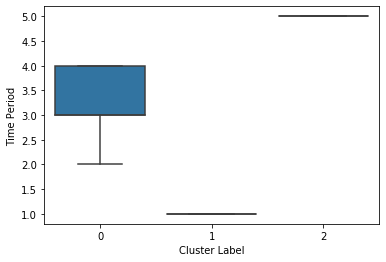

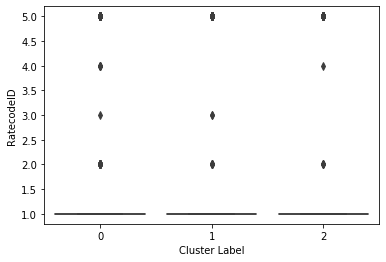

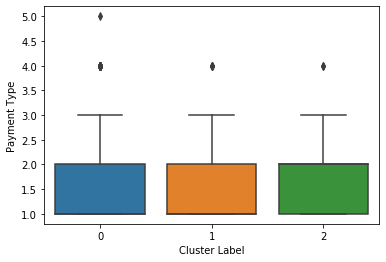

In [28]:
cluster_1 = k_clusters_green_modes1[0]
cluster_2 = k_clusters_green_modes1[1]
cluster_3 = k_clusters_green_modes1[2]
plot_cluster_per_atttribute_3(0,cluster_1,cluster_2,cluster_3,'Time Period')
plot_cluster_per_atttribute_3(1,cluster_1,cluster_2,cluster_3,'RatecodeID')
plot_cluster_per_atttribute_3(2,cluster_1,cluster_2,cluster_3,'Payment Type')

In [29]:
k2 = 5
print('k =',k2)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_modes2 = k_modes(k2, categorical_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 5 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 5
Start at 05:02:40
[[4, 1.0, 1.0], [1, 1.0, 1.0], [3, 1.0, 1.0], [4, 5.0, 2.0], [3, 1.0, 2.0]]
False iteration 0
[array([4., 1., 1.]), array([1., 1., 1.]), array([3., 1., 1.]), array([2., 5., 1.]), array([3., 1., 2.])]
False iteration 1
[array([4., 1., 1.]), array([1., 1., 1.]), array([3., 1., 1.]), array([2., 5., 1.]), array([3., 1., 2.])]
Stop at 05:02:42
K-Modes Clustering with k = 5 on 171,939 data points took 0.03 minutes


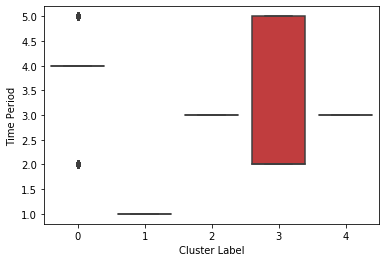

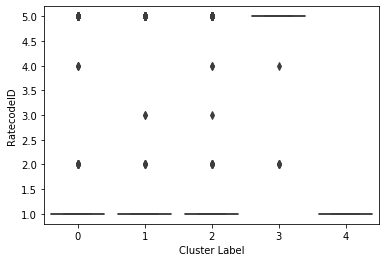

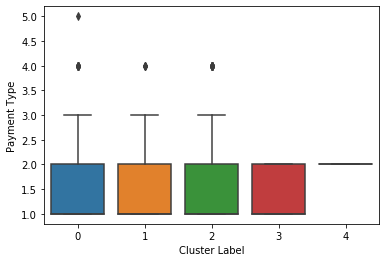

In [30]:
cluster_1 = k_clusters_green_modes2[0]
cluster_2 = k_clusters_green_modes2[1]
cluster_3 = k_clusters_green_modes2[2]
cluster_4 = k_clusters_green_modes2[3]
cluster_5 = k_clusters_green_modes2[4]
plot_cluster_per_atttribute_5(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Time Period')
plot_cluster_per_atttribute_5(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'RatecodeID')
plot_cluster_per_atttribute_5(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,'Payment Type')

In [31]:
k3 = 10
print('k =',k3)
start = time.time()
print('Start at', time.strftime('%H:%M:%S', time.gmtime(start)))
k_clusters_green_modes3 = k_modes(k3, categorical_green)
end = time.time()
print('Stop at', time.strftime('%H:%M:%S', time.gmtime(end)))
print('K-Modes Clustering with k = 10 on {:,} data points took {:.2f} minutes'.format(len(numeric_yellow), (end-start)/60))

k = 10
Start at 05:02:57
[[1, 1.0, 1.0], [5, 1.0, 2.0], [5, 1.0, 1.0], [3, 1.0, 1.0], [3, 1.0, 2.0], [4, 1.0, 2.0], [2, 1.0, 1.0], [4, 1.0, 1.0], [1, 1.0, 2.0], [4, 5.0, 2.0]]
False iteration 0
[array([1., 1., 1.]), array([5., 1., 2.]), array([3., 1., 1.]), array([4., 1., 1.]), array([2., 1., 1.]), array([4., 5., 2.]), array([2., 1., 1.]), array([4., 1., 1.]), array([1., 1., 2.]), array([4., 5., 2.])]
False iteration 1
[array([1., 1., 1.]), array([5., 1., 2.]), array([3., 1., 1.]), array([4., 1., 1.]), array([2., 1., 1.]), array([4., 5., 2.]), array([2., 1., 1.]), array([4., 1., 1.]), array([1., 1., 2.]), array([4., 5., 2.])]
Stop at 05:03:01
K-Modes Clustering with k = 10 on 171,939 data points took 0.06 minutes


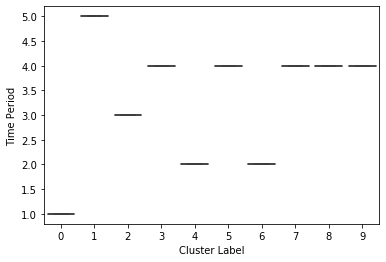

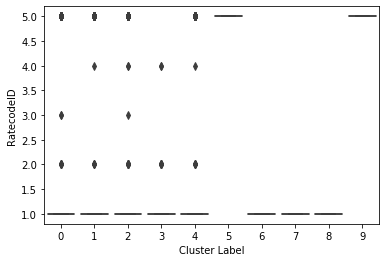

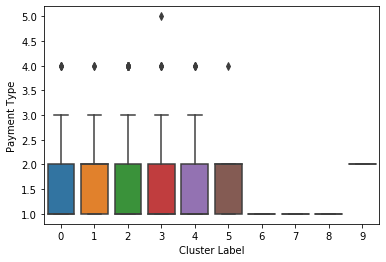

In [32]:
cluster_1 = k_clusters_green_modes3[0]
cluster_2 = k_clusters_green_modes3[1]
cluster_3 = k_clusters_green_modes3[2]
cluster_4 = k_clusters_green_modes3[3]
cluster_5 = k_clusters_green_modes3[4]
cluster_6 = k_clusters_green_modes3[5]
cluster_7 = k_clusters_green_modes3[6]
cluster_8 = k_clusters_green_modes3[7]
cluster_9 = k_clusters_green_modes3[7]
cluster_10 = k_clusters_green_modes3[9]
plot_cluster_per_atttribute_10(0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Time Period')
plot_cluster_per_atttribute_10(1,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'RatecodeID')
plot_cluster_per_atttribute_10(2,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,'Payment Type')